In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys

from sklearn.model_selection import train_test_split


import keras
from keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import *
import tensorflow as tf


RANDOM_STATE = 2020
VAL_SPLIT = 0.2

#### Select running platform to easy running on each platform:

In [21]:
PLATFORM = 'kaggle'

if PLATFORM == 'kaggle':
    path_train = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/'
    path_test  = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/'
    
elif PLATFORM == 'colab':
    path_train = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/train'
    path_test  = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/test'
    from google.colab import drive
    drive.mount('/content/drive')
    
elif PLATFORM == 'local':
    path_train = '../data/raw/train'
    path_test  = '../data/raw/test'

else:
    sys.exit('ERROR: PLEASE ENTER "kaggle", "colab" or "local"')

### Import training data:

In [22]:
BATCH_SIZE = 1349+3883
TARGET_SIZE = 128

generator = ImageDataGenerator()
gen_train = generator.flow_from_directory(directory=path_train, 
                                          target_size=(TARGET_SIZE, TARGET_SIZE), 
                                          batch_size=BATCH_SIZE, 
                                          seed=RANDOM_STATE)

train = next(gen_train)
images = train[0]
labels = train[1]
del gen_train, train # reduce memory usage

Found 5216 images belonging to 2 classes.


#### Define validation data *only* for testing model performance after fitting on 0.25 val split

In [23]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, random_state=RANDOM_STATE, test_size=VAL_SPLIT)

In [24]:
def plot_metrics(history, metrics=['accuracy'], val=True):
    
    for metric in metrics:
        x = range(len(history[metric]))

        plt.figure()
        plt.plot(x, history[metric], label='Train')

        if val == True:
            plt.plot(x, history['val_'+metric], label='Validation')
        plt.title(metric)
        plt.legend();

#### Define callbacks

In [25]:
callbacks = [EarlyStopping(monitor='val_loss', patience=50),
             ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)]

### Define First Simple Model (FSM)

##### Uses only Dense layer

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 2)                 98306     
Total params: 98,306
Trainable params: 98,306
Non-trainable params: 0
_________________________________________________________________


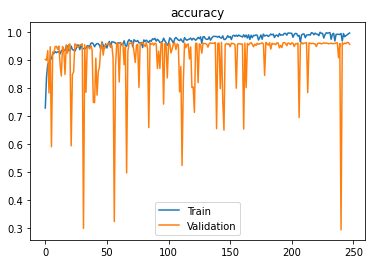

In [27]:
# Manually flatten Images array for input to Dense layer
shp = x_train.shape # temporary variable
x_train_flat = x_train.reshape(shp[0], 
                               shp[1]*shp[2]*shp[3])
shape = (x_train_flat.shape[1],)


model = Sequential()
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', 
              metrics=['accuracy'], 
              loss='categorical_crossentropy')


fit = model.fit(x=images_flat, 
                y=labels, 
                epochs=500,
                validation_data=(x_val, y_val),
                callbacks=callbacks,
                verbose=0)

plot_metrics(fit.history)

model.load_weights('best_model.h5')
model.summary()

##### Check validation data performance

In [28]:
# Manually flatten Images array for input to Dense layer
shp = x_val.shape # temporary variable
x_val_flat = x_val.reshape(shp[0], 
                             shp[1]*shp[2]*shp[3])
shape = (x_val_flat.shape[1],)

model.evaluate(x_val_flat, y_val);

41/41 [==============================] - 0s 4ms/step - loss: 3315.5015 - accuracy: 0.9908


[3315.50146484375, 0.9907975196838379]

#### Add convolutional layer to previous model

In [35]:
model = Sequential()
model.add(Conv2D(8,
                 kernel_size=2,  
                 input_shape=(TARGET_SIZE, TARGET_SIZE, 3)))

model.add(Flatten())

model.add(Dense(2, 
                activation='softmax'))

model.compile(metrics=['accuracy'], 
              loss='categorical_crossentropy')

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=callbacks,
                validation_data=(x_val, y_val),
                verbose=0)

plot_metrics(fit.history)

model.load_weights('best_model.h5')
display(model.summary())


# Print evaluation results on validation set
model.evaluate(x_val, y_val)

NameError: name 'x_train' is not defined

41/41 [==============================] - 0s 5ms/step - loss: 5.8058 - accuracy: 0.9847


[5.805794715881348, 0.9846625924110413]